In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [2]:
class TransliterationDataset(Dataset):
    def __init__(self, file_path, source_vocab=None, target_vocab=None, max_length=32, create_vocab=False):
        # Attempt to read tab-separated file containing native and romanized text
        try:
            data = pd.read_csv(file_path, sep='\t', header=None,
                               names=['native', 'roman', 'freq'],
                               usecols=[0, 1], dtype=str)
            print(f"Loaded {len(data)} records from {file_path}")

            # Replace missing entries with empty strings
            data['native'] = data['native'].fillna('')
            data['roman'] = data['roman'].fillna('')

            # Create input-output text pairs for transliteration
            self.data_pairs = list(zip(data['roman'], data['native']))
            print(f"Example pairs: {self.data_pairs[:2]}")
        except Exception as err:
            print(f"Failed to load data: {err}")
            self.data_pairs = [('', '')]  # Fallback entry

        self.max_length = max_length

        # Initialize or use existing vocabulary mappings
        if create_vocab:
            self.source_vocab = {'<pad>': 0, '<unk>': 1, '<sos>':2, '<eos>':3}
            self.target_vocab = {'<pad>': 0, '<unk>': 1, '<sos>':2, '<eos>':3}
            self._generate_vocab_function()
        else:
            self.source_vocab, self.target_vocab = source_vocab, target_vocab
            if '<eos>' not in self.source_vocab:
                self.source_vocab['<eos>'] = len(self.source_vocab)
            if '<eos>' not in self.target_vocab:
                self.target_vocab['<eos>'] = len(self.target_vocab)

    def _generate_vocab_function(self):
        # Create vocabularies at the character level from the dataset
        for src_text, tgt_text in self.data_pairs:
            for char in src_text:
                if char not in self.source_vocab:
                    self.source_vocab[char] = len(self.source_vocab)
            for char in tgt_text:
                if char not in self.target_vocab:
                    self.target_vocab[char] = len(self.target_vocab)
        print(f"Vocab sizes — Source: {len(self.source_vocab)}, Target: {len(self.target_vocab)}")

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        src_seq, tgt_seq = self.data_pairs[idx]
        
        # Convert characters to indices with bounds checking
        src_idxs = [self.source_vocab['<sos>']]  # Start with SOS token
        for ch in src_seq:
            idx = self.source_vocab.get(ch, self.source_vocab['<unk>'])
            if idx >= len(self.source_vocab):
                idx = self.source_vocab['<unk>']  # Safety check
            src_idxs.append(idx)
            
        tgt_idxs = [self.target_vocab['<sos>']]  # Start with SOS token
        for ch in tgt_seq:
            idx = self.target_vocab.get(ch, self.target_vocab['<unk>'])
            if idx >= len(self.target_vocab):
                idx = self.target_vocab['<unk>']  # Safety check
            tgt_idxs.append(idx)
        
        # Add end-of-sequence token
        src_idxs.append(self.source_vocab['<eos>'])
        tgt_idxs.append(self.target_vocab['<eos>'])
        
        # Add padding
        pad_src = [self.source_vocab['<pad>']] * max(0, self.max_length - len(src_idxs))
        pad_tgt = [self.target_vocab['<pad>']] * max(0, self.max_length - len(tgt_idxs))
        
        # Truncate if necessary and convert to tensor
        src_idxs = (src_idxs + pad_src)[:self.max_length]
        tgt_idxs = (tgt_idxs + pad_tgt)[:self.max_length]
        
        # Make sure padding index is valid
        assert self.source_vocab['<pad>'] < len(self.source_vocab), "Padding index out of bounds for source vocab"
        assert self.target_vocab['<pad>'] < len(self.target_vocab), "Padding index out of bounds for target vocab"
        
        return torch.tensor(src_idxs, dtype=torch.long), torch.tensor(tgt_idxs, dtype=torch.long)

In [3]:
class BahdanauAttention(nn.Module):
    """Bahdanau attention mechanism (additive attention)"""
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Define trainable parameters for attention mechanism
        self.W_a = nn.Linear(hidden_size * 2, hidden_size)
        self.v_a = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, query, keys):
        """
        Args:
            query: decoder hidden state [batch_size, hidden_size]
            keys: encoder outputs [batch_size, src_len, hidden_size]
        Returns:
            context: context vector [batch_size, hidden_size]
            attention_weights: attention weights [batch_size, src_len]
        """
        batch_size, src_len, _ = keys.size()
        
        # Reshape query to [batch_size, 1, hidden_size] to match keys dimensions
        query = query.unsqueeze(1).repeat(1, src_len, 1)
        
        # Concatenate query and keys
        # [batch_size, src_len, hidden_size * 2]
        energy_input = torch.cat((query, keys), dim=2)
        
        # Calculate energy [batch_size, src_len, hidden_size]
        energy = torch.tanh(self.W_a(energy_input))
        
        # Calculate attention scores [batch_size, src_len, 1]
        attention = self.v_a(energy)
        
        # Remove last dimension and apply softmax
        # [batch_size, src_len]
        attention_weights = F.softmax(attention.squeeze(2), dim=1)
        
        # Calculate weighted sum of encoder outputs (context vector)
        # [batch_size, 1, src_len] x [batch_size, src_len, hidden_size] -> [batch_size, 1, hidden_size]
        context = torch.bmm(attention_weights.unsqueeze(1), keys)
        
        # Remove dimension 1 -> [batch_size, hidden_size]
        context = context.squeeze(1)
        
        return context, attention_weights

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_vocab_size, embedding_size, hidden_size, num_layers, dropout=0.0, cell_type='GRU'):
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        
        # Choose appropriate RNN cell
        if cell_type == 'RNN':
            rnn_cell = nn.RNN
        elif cell_type == 'GRU':
            rnn_cell = nn.GRU
        elif cell_type == 'LSTM':
            rnn_cell = nn.LSTM
        else:
            raise ValueError(f"RNN type not recognized: {cell_type}")
        
        self.rnn = rnn_cell(
            embedding_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
    
    def forward(self, x):
        """
        Args:
            x: input sequence [batch_size, seq_len]
        Returns:
            outputs: encoder outputs [batch_size, seq_len, hidden_size]
            hidden: final hidden state [num_layers, batch_size, hidden_size]
        """
        # Apply embedding layer: [batch_size, seq_len] -> [batch_size, seq_len, embedding_size]
        embedded = self.embedding(x)
        
        # Pass through RNN
        outputs, hidden = self.rnn(embedded)
        
        return outputs, hidden

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, output_vocab_size, embedding_size, hidden_size, num_layers, dropout=0.0, cell_type='GRU'):
        super().__init__()
        self.output_vocab_size = output_vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        
        self.embedding = nn.Embedding(output_vocab_size, embedding_size, padding_idx=0)
        
        # Attention mechanism
        self.attention = BahdanauAttention(hidden_size)
        
        # For concatenating embedding and context vector
        self.rnn_input_size = embedding_size + hidden_size
        
        # Choose appropriate RNN cell
        if cell_type == 'RNN':
            rnn_cell = nn.RNN
        elif cell_type == 'GRU':
            rnn_cell = nn.GRU
        elif cell_type == 'LSTM':
            rnn_cell = nn.LSTM
        else:
            raise ValueError(f"RNN type not recognized: {cell_type}")
        
        self.rnn = rnn_cell(
            self.rnn_input_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        
        # Linear layer to produce output logits
        self.output_projection = nn.Linear(hidden_size * 2, output_vocab_size)
    
    def forward(self, input_token, last_hidden, encoder_outputs):
        """
        Args:
            input_token: input token indices [batch_size, 1]
            last_hidden: previous decoder hidden state
            encoder_outputs: encoder outputs [batch_size, src_len, hidden_size]
        Returns:
            output: output logits [batch_size, output_vocab_size]
            hidden: new hidden state
            attn_weights: attention weights [batch_size, src_len]
        """
        # Get embedding for input token [batch_size, 1, embedding_size]
        embedded = self.embedding(input_token)
        
        # Get current hidden state to use for attention
        if self.cell_type == 'LSTM':
            current_hidden = last_hidden[0][-1]  # Use the last layer's hidden state
        else:
            current_hidden = last_hidden[-1]  # Use the last layer's hidden state
        
        # Apply attention mechanism
        context, attn_weights = self.attention(current_hidden, encoder_outputs)
        
        # Combine embedding and context vector [batch_size, 1, embedding_size + hidden_size]
        rnn_input = torch.cat((embedded, context.unsqueeze(1)), dim=2)
        
        # Pass through RNN
        output, hidden = self.rnn(rnn_input, last_hidden)
        
        # Combine RNN output with context vector for better prediction
        output = torch.cat((output.squeeze(1), context), dim=1)
        
        # Project to vocabulary space [batch_size, output_vocab_size]
        output = self.output_projection(output)
        
        return output, hidden, attn_weights

In [6]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, config, input_vocab_size, output_vocab_size):
        super().__init__()

        # Ensure vocabulary sizes are positive
        assert input_vocab_size > 0, f"Source vocab size invalid: {input_vocab_size}"
        assert output_vocab_size > 0, f"Target vocab size invalid: {output_vocab_size}"

        # Hyperparameter setup
        self.embedding_size = config.embed_dim
        self.hidden_size = config.hidden_dim
        self.rnn_type = config.cell_type
        self.encoder_layers = config.num_layers
        self.decoder_layers = config.num_layers
        
        # Initialize encoder and decoder
        self.encoder = EncoderRNN(
            input_vocab_size, 
            config.embed_dim, 
            config.hidden_dim, 
            config.num_layers, 
            config.dropout, 
            config.cell_type
        )
        
        self.decoder = DecoderRNN(
            output_vocab_size, 
            config.embed_dim, 
            config.hidden_dim, 
            config.num_layers, 
            config.dropout, 
            config.cell_type
        )
        
        # For accessing embeddings in training/inference_function
        self.input_embedding = self.encoder.embedding
        self.output_embedding = self.decoder.embedding

        print(f"Initialized model with attention: {self.rnn_type}, Encoder layers: {self.encoder_layers}, "
              f"Decoder layers: {self.decoder_layers}, Embedding: {self.embedding_size}, Hidden: {self.hidden_size}")

    def forward(self, source_seq, target_seq):
        """
        Forward pass through the entire seq2seq model.
        
        Args:
            source_seq: source sequence [batch_size, src_len]
            target_seq: target sequence [batch_size, tgt_len]
        
        Returns:
            outputs: output logits [batch_size, tgt_len-1, output_vocab_size]
        """
        batch_size, tgt_len = target_seq.size()
        device = source_seq.device

        # Index range check and clamping
        if source_seq.max() >= self.input_embedding.num_embeddings:
            print("Warning: Source index out of bounds")
            source_seq = torch.clamp(source_seq, 0, self.input_embedding.num_embeddings - 1)
        if target_seq.max() >= self.output_embedding.num_embeddings:
            print("Warning: Target index out of bounds")
            target_seq = torch.clamp(target_seq, 0, self.output_embedding.num_embeddings - 1)

        try:
            # Encode source sequence
            encoder_outputs, encoder_hidden = self.encoder(source_seq)
            
            # Initialize decoder hidden state with encoder final state
            decoder_hidden = encoder_hidden
            
            # Teacher forcing: feed target as the next input
            decoder_input = target_seq[:, :-1]  # Input: from <sos> to the second-to-last token
            # Store all decoder outputs
            outputs = torch.zeros(batch_size, tgt_len-1, self.decoder.output_vocab_size, device=device)
            
            # Process one token at a time
            for t in range(tgt_len-1):
                # Get token for current timestep
                current_input = target_seq[:, t].unsqueeze(1)
                
                # Forward through decoder
                decoder_output, decoder_hidden, _ = self.decoder(
                    current_input,
                    decoder_hidden,
                    encoder_outputs
                )
                
                # Store prediction
                outputs[:, t, :] = decoder_output
            
            return outputs
            
        except Exception as err:
            print(f"Forward pass exception: {err}")
            return torch.zeros(batch_size, tgt_len-1, self.decoder.output_vocab_size, device=device)

    def inference_function(self, source_seq, max_length=50, beam_size=1):
        """
        Generate transliteration using beam search.
        
        Args:
            source_seq: source sequence [batch_size, src_len]
            max_length: maximum length of generated sequence
            beam_size: beam size for beam search
            
        Returns:
            generated_seq: generated sequence [batch_size, max_length]
        """
        batch_size = source_seq.size(0)
        device = source_seq.device
        
        # Encode source sequence
        encoder_outputs, encoder_hidden = self.encoder(source_seq)
        
        if beam_size == 1:
            # Greedy search
            decoder_hidden = encoder_hidden
            decoder_input = torch.tensor([[2]], device=device).repeat(batch_size, 1)  # Start with <sos> token
            generated_tokens = torch.zeros(batch_size, max_length, dtype=torch.long, device=device)

            # Store attention weights for each step
            attention_weights = torch.zeros(batch_size, max_length, source_seq.size(1), device=device)
            
            for t in range(max_length):
                # Forward through decoder
                decoder_output, decoder_hidden, attn_weights = self.decoder(
                    decoder_input,
                    decoder_hidden,
                    encoder_outputs
                )
                
                # Get most likely token
                _, topi = decoder_output.topk(1)
                decoder_input = topi.view(batch_size, 1)
                
                # Save generated token
                generated_tokens[:, t] = decoder_input.squeeze(1)

                # Save attention weights
                attention_weights[:, t, :] = attn_weights
                
                # Stop if all sequences generated <eos>
                if (decoder_input == 3).all():  # 3 is <eos> token index
                    break
            
            return generated_tokens, attention_weights
        else:
            # Implement beam search here (omitted for brevity)
            # For now, return greedy search result
            return self.inference_function(source_seq, max_length, beam_size=1)

In [7]:
def compute_accuracy_function(logits, target, pad_idx=0):
    """
    Computes accuracy excluding padding tokens.
    """
    preds = logits.argmax(dim=-1)
    mask = target != pad_idx
    correct = (preds == target) & mask
    acc = correct.sum().item() / max(mask.sum().item(), 1)  # Avoid division by zero
    return acc

In [8]:
def run_epoch_function(model, data_loader, loss_fn, optim, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_batches = len(data_loader)
    processed_batches = 0

    for i, (inputs, targets) in enumerate(data_loader):
        try:
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Check for out-of-vocabulary token indices
            if inputs.max().item() >= model.input_embedding.num_embeddings or \
               targets.max().item() >= model.output_embedding.num_embeddings:
                print(f"Skipping batch {i}/{total_batches} - "
                      f"Input max: {inputs.max().item()}, Target max: {targets.max().item()}, "
                      f"Input vocab size: {model.input_embedding.num_embeddings}, "
                      f"Target vocab size: {model.output_embedding.num_embeddings}")
                continue

            # Reset gradients
            optim.zero_grad()

            # Model inference_function
            output_logits = model(inputs, targets)

            # Flatten predictions and targets for loss function
            pred_flat = output_logits.reshape(-1, output_logits.size(-1))
            true_flat = targets[:, 1:].reshape(-1)  # Shift targets by one for teacher forcing

            # Compute loss and perform optimization
            loss = loss_fn(pred_flat, true_flat)
            loss.backward()
            
            # Apply gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optim.step()

            total_loss += loss.item()
                
            # Accuracy
            acc = compute_accuracy_function(output_logits, targets[:, 1:])
            total_acc += acc
            processed_batches += 1

        except Exception as err:
            print(f"Error in batch {i}/{total_batches}: {err}")
            continue

    if processed_batches == 0:
        return 0.0, 0.0
    return total_loss / processed_batches, total_acc / processed_batches

In [56]:
def validate_model1(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    processed_batches = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            try:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Ensure token indices are within valid vocabulary range
                if inputs.max() >= model.input_embedding.num_embeddings or \
                   targets.max() >= model.output_embedding.num_embeddings:
                    continue  # Skip batch if invalid indices found

                # Forward propagation
                predictions = model(inputs, targets)

                # Flatten tensors for loss calculation
                pred_flat = predictions.reshape(-1, predictions.size(-1))
                target_flat = targets[:, 1:].reshape(-1)  # Shift targets by one for teacher forcing

                # Compute batch loss
                loss = loss_fn(pred_flat, target_flat)
                total_loss += loss.item()
                
                # Compute accuracy
                acc = compute_accuracy_function(predictions, targets[:, 1:])
                total_acc += acc
                processed_batches += 1

            except Exception as ex:
                print(f"Evaluation error: {ex}")
                continue

    if processed_batches == 0:
        return 0.0, 0.0
    return total_loss / processed_batches, total_acc / processed_batches

In [10]:
def export_vocabularies_function(directory, source_dict, target_dict):
    """Export source and target vocabularies to JSON format."""
    os.makedirs(directory, exist_ok=True)
    
    src_path = os.path.join(directory, 'src.json')
    tgt_path = os.path.join(directory, 'tgt.json')
    
    with open(src_path, 'w', encoding='utf-8') as src_file:
        json.dump(source_dict, src_file, indent=2, ensure_ascii=False)
        
    with open(tgt_path, 'w', encoding='utf-8') as tgt_file:
        json.dump(target_dict, tgt_file, indent=2, ensure_ascii=False)

def import_vocabularies_function(directory):
    """Import source and target vocabularies from JSON files."""
    with open(os.path.join(directory, 'src.json'), 'r', encoding='utf-8') as src_file:
        source_dict = json.load(src_file)
        
    with open(os.path.join(directory, 'tgt.json'), 'r', encoding='utf-8') as tgt_file:
        target_dict = json.load(tgt_file)
        
    return source_dict, target_dict

In [ ]:
# Dataset paths
path_train = '/kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv'
path_dev = '/kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv'
vocab_dir = '/kaggle/working/vocab'

print("Generating vocabularies...")
train_data = TransliterationDataset(path_train, create_vocab=True)
src_vocab, tgt_vocab = train_data.source_vocab, train_data.target_vocab

export_vocabularies_function(vocab_dir, src_vocab, tgt_vocab)
print(f"Source vocab: {len(src_vocab)}, Target vocab: {len(tgt_vocab)}")

# Display sample vocab entries
print("Source vocab sample:")
for ch, idx in list(src_vocab.items())[:10]:
    print(f"  {repr(ch)} => {idx}")
print("Target vocab sample:")
for ch, idx in list(tgt_vocab.items())[:10]:
    print(f"  {repr(ch)} => {idx}")

In [12]:
def run_sweep_function():
    """Function to run for each sweep configuration"""
    run = wandb.init()
    cfg = run.config
        
    # Create a descriptive run name
    run.name = f"{cfg.cell_type}-e{cfg.embed_dim}-h{cfg.hidden_dim}-enc{cfg.num_layers}-dec{cfg.num_layers}-d{cfg.dropout}-lr{cfg.learning_rate}-b{cfg.batch_size}-beam{cfg.beam_size}"
        
    # Set device - force CPU initially if CUDA issues were detected
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 10
    
    # Load vocabularies
    try:
        src_vocab, tgt_vocab = import_vocabularies_function(vocab_dir)
        print(f"Loaded vocabularies: Source: {len(src_vocab)}, Target: {len(tgt_vocab)}")
    except Exception as e:
        print(f"Error loading vocabularies: {e}")
        print("Generating vocabularies...")
        train_data = TransliterationDataset(path_train, create_vocab=True)
        src_vocab, tgt_vocab = train_data.source_vocab, train_data.target_vocab
        export_vocabularies_function(vocab_dir, src_vocab, tgt_vocab)
    
    # Initialize model
    try:
        # First create on CPU
        model = Seq2SeqWithAttention(cfg, len(src_vocab), len(tgt_vocab))
        print("Model created on CPU, trying to move to device...")
        # Then try to move to target device
        model = model.to(device)
        print("Model successfully moved to device.")
    except Exception as e:
        print(f"Error initializing model on {device}: {e}")
        print("Falling back to CPU")
        device = torch.device('cpu')
        model = Seq2SeqWithAttention(cfg, len(src_vocab), len(tgt_vocab)).to(device)
        
    # Load datasets
    try:
        print("Loading datasets...")
        train_dataset = TransliterationDataset(path_train, src_vocab, tgt_vocab)
        dev_dataset = TransliterationDataset(path_dev, src_vocab, tgt_vocab)
            
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
        dev_loader = DataLoader(dev_dataset, batch_size=cfg.batch_size)
    except Exception as e:
        print(f"Error loading datasets: {e}")
        return
        
    # Initialize loss function and optimizer
    try:
        criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 is padding index
        optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
        
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=2, verbose=True
        )
    except Exception as e:
        print(f"Error initializing criterion or optimizer: {e}")
        return
        
    # Training loop
    best_val_acc = 0.0
        
    try:
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
                
            # Training
            train_loss, train_acc = run_epoch_function(model, train_loader, criterion, optimizer, device)
            print(f"Train loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")
                
            # Validation
            val_loss, val_acc = validate_model(model, dev_loader, criterion, device)
            print(f"Validation loss: {val_loss:.4f} Validation Accuracy: {val_acc:.4f} ")
            
            # Update learning rate
            scheduler.step(val_loss)
                
            # Log metrics
            wandb.log({
                'train_loss': train_loss, 
                'val_loss': val_loss, 
                'train_acc': train_acc, 
                'val_acc': val_acc, 
                'epoch': epoch
            })
                
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                print(f"New best model with validation accuracy: {best_val_acc:.4f}")
                
        wandb.log({'val_accuracy': best_val_acc})
        
                    
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

In [13]:
# Configure sweep 
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'cell_type': {'values': ['RNN', 'LSTM', 'GRU']},
        'embed_dim': {'values': [64, 128, 256]},
        'hidden_dim': {'values': [256, 512]},
        'num_layers': {'values': [1, 2, 3]},
        'dropout': {'values': [0.0, 0.1, 0.2]},
        'learning_rate': {'values': [0.001, 0.0005, 0.0001]},
        'batch_size': {'values': [32, 64, 128]},
        'beam_size': {'values': [1, 3, 5]}
    }
}

In [14]:
wandb.login(key = "d6f8c99f1fd73267470842bbf00f03ae845f7308")
sweep_id = wandb.sweep(sweep_config, project="DLA3")
wandb.agent(sweep_id, run_sweep_function, count=20)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: da24m014 (da24m014-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: z8hzeqkz
Sweep URL: https://wandb.ai/da24m014-iit-madras/DLA3/sweeps/z8hzeqkz


wandb: Agent Starting Run: ncuoq3xs with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dropout: 0
wandb: 	embed_dim: 128
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: GRU, Encoder layers: 2, Decoder layers: 2, Embedding: 128, Hidden: 256
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
Train loss: 1.2510 Train Accuracy: 0.6546
Validation loss: 0.5600 Validation Accuracy: 0.8213 
New best model with validation accuracy: 0.8213
Epoch 2/10
Train loss: 0.4251 Train Accuracy: 0.8625
Validation loss: 0.4560 Validation Accuracy: 0.8453 
New best model with validation accuracy: 0.8453
Epoch 3/10
Train loss: 0.3292 Train Accuracy: 0.8932
Validation loss: 0.4042 Validation Accuracy: 0.8647 
New best model with validation accuracy: 0.8647
Epoch 4/10
Train loss: 0.2752 Train Accuracy: 0.9112
Validation loss: 0.3959 Validation Accuracy: 0.8700 
New best model with validation accuracy: 0.8700
Epoch 5/10
Train loss: 0.2363 Train Accuracy: 0.9232
Validation loss: 0.3884 Validation Accuracy: 0.8727 
New best model with validation accuracy: 0.8727
Epoch 6/10
Train loss: 0.2056 Train Accuracy: 0.9335
Validation loss: 0.3831 Validation Accuracy: 0.8797 
New best model with validation accuracy: 0.8797
Epoch 7/10
Train loss: 0.1816 Train Accuracy: 0.9410
Validation loss: 0.3859

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▄▆▆▇█████
val_accuracy,▁
val_loss,█▄▂▂▁▁▁▁▂▁
epoch,9
train_acc,0.96279
train_loss,0.11575
val_acc,0.88362
val_accuracy,0.88362


wandb: Agent Starting Run: c6gk46tu with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 1, Decoder layers: 1, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.5368 Train Accuracy: 0.8321
Validation loss: 0.4178 Validation Accuracy: 0.8610 
New best model with validation accuracy: 0.8610
Epoch 2/10
Train loss: 0.2574 Train Accuracy: 0.9145
Validation loss: 0.3829 Validation Accuracy: 0.8749 
New best model with validation accuracy: 0.8749
Epoch 3/10
Train loss: 0.1956 Train Accuracy: 0.9349
Validation loss: 0.4003 Validation Accuracy: 0.8743 
Epoch 4/10
Train loss: 0.1612 Train Accuracy: 0.9468
Validation loss: 0.3974 Validation Accuracy: 0.8786 
New best model with validation accuracy: 0.8786
Epoch 5/10
Train loss: 0.1364 Train Accuracy: 0.9552
Validation loss: 0.4137 Validation Accuracy: 0.8788 
New best model with validation accuracy: 0.8788
Epoch 6/10
Train loss: 0.0877 Train Accuracy: 0.9710
Validation loss: 0.4044 Validation Accuracy: 0.8877 
New best model with validation accuracy: 0.8877
Epoch 7/10
Train loss: 0.0691 Train Accuracy: 0.9776
Validation loss: 0.4206 Validation Accuracy: 0.8862 
Epoch 8/10
Train loss: 0.0609

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▇▇████
train_loss,█▄▃▃▂▂▁▁▁▁
val_acc,▁▄▄▅▅▇▇▇█▇
val_accuracy,▁
val_loss,▅▁▃▂▄▃▅▆▆█
epoch,9
train_acc,0.9881
train_loss,0.03542
val_acc,0.88897
val_accuracy,0.89236


wandb: Agent Starting Run: lm58nv1i with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0
wandb: 	embed_dim: 64
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 3, Decoder layers: 3, Embedding: 64, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.2625 Train Accuracy: 0.6409
Validation loss: 0.4942 Validation Accuracy: 0.8404 
New best model with validation accuracy: 0.8404
Epoch 2/10
Train loss: 0.3335 Train Accuracy: 0.8917
Validation loss: 0.4397 Validation Accuracy: 0.8604 
New best model with validation accuracy: 0.8604
Epoch 3/10
Train loss: 0.2361 Train Accuracy: 0.9231
Validation loss: 0.4065 Validation Accuracy: 0.8728 
New best model with validation accuracy: 0.8728
Epoch 4/10
Train loss: 0.1819 Train Accuracy: 0.9408
Validation loss: 0.4048 Validation Accuracy: 0.8778 
New best model with validation accuracy: 0.8778
Epoch 5/10
Train loss: 0.1423 Train Accuracy: 0.9535
Validation loss: 0.4146 Validation Accuracy: 0.8794 
New best model with validation accuracy: 0.8794
Epoch 6/10
Train loss: 0.1144 Train Accuracy: 0.9626
Validation loss: 0.4327 Validation Accuracy: 0.8806 
New best model with validation accuracy: 0.8806
Epoch 7/10
Train loss: 0.0994 Train Accuracy: 0.9677
Validation loss: 0.4477 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇███
val_accuracy,▁
val_loss,█▄▁▁▂▃▄▄▆█
epoch,9
train_acc,0.98841
train_loss,0.0359
val_acc,0.88791
val_accuracy,0.88919


wandb: Agent Starting Run: 2zmnrupj with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 1, Decoder layers: 1, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.6138 Train Accuracy: 0.8132
Validation loss: 0.4145 Validation Accuracy: 0.8611 
New best model with validation accuracy: 0.8611
Epoch 2/10
Train loss: 0.2677 Train Accuracy: 0.9117
Validation loss: 0.3830 Validation Accuracy: 0.8731 
New best model with validation accuracy: 0.8731
Epoch 3/10
Train loss: 0.2010 Train Accuracy: 0.9336
Validation loss: 0.3777 Validation Accuracy: 0.8815 
New best model with validation accuracy: 0.8815
Epoch 4/10
Train loss: 0.1600 Train Accuracy: 0.9470
Validation loss: 0.3824 Validation Accuracy: 0.8824 
New best model with validation accuracy: 0.8824
Epoch 5/10
Train loss: 0.1334 Train Accuracy: 0.9558
Validation loss: 0.3980 Validation Accuracy: 0.8829 
New best model with validation accuracy: 0.8829
Epoch 6/10
Train loss: 0.1169 Train Accuracy: 0.9611
Validation loss: 0.4093 Validation Accuracy: 0.8837 
New best model with validation accuracy: 0.8837
Epoch 7/10
Train loss: 0.0746 Train Accuracy: 0.9754
Validation loss: 0.4035 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▄▆▆▆▆▇▇▇█
val_accuracy,▁
val_loss,▅▂▁▂▃▅▄▆██
epoch,9
train_acc,0.98707
train_loss,0.03895
val_acc,0.8913
val_accuracy,0.8913


wandb: Agent Starting Run: i0hhxgxb with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: RNN, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7550 Train Accuracy: 0.7708
Validation loss: 0.4731 Validation Accuracy: 0.8437 
New best model with validation accuracy: 0.8437
Epoch 2/10
Train loss: 0.3517 Train Accuracy: 0.8829
Validation loss: 0.4117 Validation Accuracy: 0.8610 
New best model with validation accuracy: 0.8610
Epoch 3/10
Train loss: 0.2815 Train Accuracy: 0.9063
Validation loss: 0.4090 Validation Accuracy: 0.8691 
New best model with validation accuracy: 0.8691
Epoch 4/10
Train loss: 0.2422 Train Accuracy: 0.9191
Validation loss: 0.3953 Validation Accuracy: 0.8720 
New best model with validation accuracy: 0.8720
Epoch 5/10
Train loss: 0.2148 Train Accuracy: 0.9282
Validation loss: 0.4003 Validation Accuracy: 0.8718 
Epoch 6/10
Train loss: 0.1951 Train Accuracy: 0.9350
Validation loss: 0.4048 Validation Accuracy: 0.8744 
New best model with validation accuracy: 0.8744
Epoch 7/10
Train loss: 0.1782 Train Accuracy: 0.9406
Validation loss: 0.4024 Validation Accuracy: 0.8789 
New best model with validatio

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▄▅▆▆▆▇███
val_accuracy,▁
val_loss,█▃▃▂▂▂▂▁▂▃
epoch,9
train_acc,0.96165
train_loss,0.11481
val_acc,0.88531
val_accuracy,0.88531


wandb: Agent Starting Run: 56edl2lr with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.8384 Train Accuracy: 0.7536
Validation loss: 0.4407 Validation Accuracy: 0.8510 
New best model with validation accuracy: 0.8510
Epoch 2/10
Train loss: 0.2897 Train Accuracy: 0.9045
Validation loss: 0.3902 Validation Accuracy: 0.8714 
New best model with validation accuracy: 0.8714
Epoch 3/10
Train loss: 0.2113 Train Accuracy: 0.9306
Validation loss: 0.3787 Validation Accuracy: 0.8822 
New best model with validation accuracy: 0.8822
Epoch 4/10
Train loss: 0.1651 Train Accuracy: 0.9459
Validation loss: 0.3770 Validation Accuracy: 0.8843 
New best model with validation accuracy: 0.8843
Epoch 5/10
Train loss: 0.1354 Train Accuracy: 0.9554
Validation loss: 0.4004 Validation Accuracy: 0.8822 
Epoch 6/10
Train loss: 0.1130 Train Accuracy: 0.9623
Validation loss: 0.4120 Validation Accuracy: 0.8832 
Epoch 7/10
Train loss: 0.0986 Train Accuracy: 0.9673
Validation loss: 0.4183 Validation Accuracy: 0.8835 
Epoch 8/10
Train loss: 0.0625 Train Accuracy: 0.9793
Validation loss: 0.4223 

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▆▇▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁
val_acc,▁▅▇▇▇▇▇███
val_accuracy,▁
val_loss,▇▂▁▁▃▄▅▅▇█
epoch,9
train_acc,0.9855
train_loss,0.04385
val_acc,0.89024
val_accuracy,0.89024


wandb: Agent Starting Run: et18etxc with config:
wandb: 	batch_size: 32
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: GRU, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.5356 Train Accuracy: 0.8310
Validation loss: 0.4289 Validation Accuracy: 0.8584 
New best model with validation accuracy: 0.8584
Epoch 2/10
Train loss: 0.2708 Train Accuracy: 0.9102
Validation loss: 0.4257 Validation Accuracy: 0.8658 
New best model with validation accuracy: 0.8658
Epoch 3/10
Train loss: 0.2186 Train Accuracy: 0.9278
Validation loss: 0.4202 Validation Accuracy: 0.8732 
New best model with validation accuracy: 0.8732
Epoch 4/10
Train loss: 0.1900 Train Accuracy: 0.9370
Validation loss: 0.4349 Validation Accuracy: 0.8706 
Epoch 5/10
Train loss: 0.1727 Train Accuracy: 0.9426
Validation loss: 0.4341 Validation Accuracy: 0.8768 
New best model with validation accuracy: 0.8768
Epoch 6/10
Train loss: 0.1609 Train Accuracy: 0.9469
Validation loss: 0.4437 Validation Accuracy: 0.8740 
Epoch 7/10
Train loss: 0.1023 Train Accuracy: 0.9663
Validation loss: 0.4204 Validation Accuracy: 0.8863 
New best model with validation accuracy: 0.8863
Epoch 8/10
Train loss: 0.0774

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▅▆▆▆▇███
train_loss,█▄▃▃▃▃▂▁▁▁
val_acc,▁▃▄▄▅▅█▇▇█
val_accuracy,▁
val_loss,▂▂▁▃▃▅▁▄█▇
epoch,9
train_acc,0.98469
train_loss,0.04733
val_acc,0.88823
val_accuracy,0.88823


wandb: Agent Starting Run: lyb2q1u2 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.8089 Train Accuracy: 0.7607
Validation loss: 0.4385 Validation Accuracy: 0.8553 
New best model with validation accuracy: 0.8553
Epoch 2/10
Train loss: 0.2952 Train Accuracy: 0.9026
Validation loss: 0.3821 Validation Accuracy: 0.8733 
New best model with validation accuracy: 0.8733
Epoch 3/10
Train loss: 0.2169 Train Accuracy: 0.9281
Validation loss: 0.3852 Validation Accuracy: 0.8781 
New best model with validation accuracy: 0.8781
Epoch 4/10
Train loss: 0.1722 Train Accuracy: 0.9426
Validation loss: 0.3925 Validation Accuracy: 0.8821 
New best model with validation accuracy: 0.8821
Epoch 5/10
Train loss: 0.1432 Train Accuracy: 0.9522
Validation loss: 0.3967 Validation Accuracy: 0.8834 
New best model with validation accuracy: 0.8834
Epoch 6/10
Train loss: 0.0921 Train Accuracy: 0.9697
Validation loss: 0.3877 Validation Accuracy: 0.8924 
New best model with validation accuracy: 0.8924
Epoch 7/10
Train loss: 0.0730 Train Accuracy: 0.9761
Validation loss: 0.4091 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▁▁▁▁▁
val_acc,▁▄▅▆▆██▇██
val_accuracy,▁
val_loss,█▁▁▂▃▂▄▇▇█
epoch,9
train_acc,0.98706
train_loss,0.03957
val_acc,0.89415
val_accuracy,0.89415


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3o3c8sul with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7739 Train Accuracy: 0.7704
Validation loss: 0.4278 Validation Accuracy: 0.8594 
New best model with validation accuracy: 0.8594
Epoch 2/10
Train loss: 0.2822 Train Accuracy: 0.9071
Validation loss: 0.3851 Validation Accuracy: 0.8746 
New best model with validation accuracy: 0.8746
Epoch 3/10
Train loss: 0.2062 Train Accuracy: 0.9321
Validation loss: 0.3896 Validation Accuracy: 0.8755 
New best model with validation accuracy: 0.8755
Epoch 4/10
Train loss: 0.1606 Train Accuracy: 0.9470
Validation loss: 0.3887 Validation Accuracy: 0.8824 
New best model with validation accuracy: 0.8824
Epoch 5/10
Train loss: 0.1311 Train Accuracy: 0.9567
Validation loss: 0.4036 Validation Accuracy: 0.8777 
Epoch 6/10
Train loss: 0.0830 Train Accuracy: 0.9728
Validation loss: 0.4025 Validation Accuracy: 0.8900 
New best model with validation accuracy: 0.8900
Epoch 7/10
Train loss: 0.0653 Train Accuracy: 0.9782
Validation loss: 0.4191 Validation Accuracy: 0.8873 
Epoch 8/10
Train loss: 0.0571

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▁▁▁▁▁
val_acc,▁▄▄▆▅█▇▇██
val_accuracy,▁
val_loss,▅▁▁▁▃▃▄▆▆█
epoch,9
train_acc,0.98862
train_loss,0.03366
val_acc,0.89087
val_accuracy,0.89159


wandb: Agent Starting Run: xzc1jpg7 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 1


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: GRU, Encoder layers: 1, Decoder layers: 1, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.6766 Train Accuracy: 0.7955
Validation loss: 0.4321 Validation Accuracy: 0.8558 
New best model with validation accuracy: 0.8558
Epoch 2/10
Train loss: 0.2912 Train Accuracy: 0.9039
Validation loss: 0.3777 Validation Accuracy: 0.8740 
New best model with validation accuracy: 0.8740
Epoch 3/10
Train loss: 0.2159 Train Accuracy: 0.9291
Validation loss: 0.3609 Validation Accuracy: 0.8834 
New best model with validation accuracy: 0.8834
Epoch 4/10
Train loss: 0.1709 Train Accuracy: 0.9441
Validation loss: 0.3726 Validation Accuracy: 0.8845 
New best model with validation accuracy: 0.8845
Epoch 5/10
Train loss: 0.1391 Train Accuracy: 0.9545
Validation loss: 0.3832 Validation Accuracy: 0.8833 
Epoch 6/10
Train loss: 0.1168 Train Accuracy: 0.9616
Validation loss: 0.4066 Validation Accuracy: 0.8834 
Epoch 7/10
Train loss: 0.0774 Train Accuracy: 0.9751
Validation loss: 0.3887 Validation Accuracy: 0.8904 
New best model with validation accuracy: 0.8904
Epoch 8/10
Train loss: 0.0638

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▆▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▅▆▇▆▇████
val_accuracy,▁
val_loss,█▃▁▂▃▅▄▆▆▇
epoch,9
train_acc,0.98615
train_loss,0.04252
val_acc,0.89091
val_accuracy,0.89091


wandb: Agent Starting Run: 57isp23f with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7622 Train Accuracy: 0.7723
Validation loss: 0.4249 Validation Accuracy: 0.8608 
New best model with validation accuracy: 0.8608
Epoch 2/10
Train loss: 0.2878 Train Accuracy: 0.9046
Validation loss: 0.3904 Validation Accuracy: 0.8728 
New best model with validation accuracy: 0.8728
Epoch 3/10
Train loss: 0.2127 Train Accuracy: 0.9293
Validation loss: 0.3713 Validation Accuracy: 0.8797 
New best model with validation accuracy: 0.8797
Epoch 4/10
Train loss: 0.1692 Train Accuracy: 0.9437
Validation loss: 0.3822 Validation Accuracy: 0.8820 
New best model with validation accuracy: 0.8820
Epoch 5/10
Train loss: 0.1400 Train Accuracy: 0.9534
Validation loss: 0.3909 Validation Accuracy: 0.8857 
New best model with validation accuracy: 0.8857
Epoch 6/10
Train loss: 0.1188 Train Accuracy: 0.9604
Validation loss: 0.3987 Validation Accuracy: 0.8869 
New best model with validation accuracy: 0.8869
Epoch 7/10
Train loss: 0.0776 Train Accuracy: 0.9743
Validation loss: 0.4009 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,▁▄▅▆▆▇██▇█
val_accuracy,▁
val_loss,▆▃▁▂▃▄▄▅▇█
epoch,9
train_acc,0.9869
train_loss,0.03996
val_acc,0.89317
val_accuracy,0.89317


wandb: Agent Starting Run: edzjdi2b with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 1, Decoder layers: 1, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7805 Train Accuracy: 0.7695
Validation loss: 0.4260 Validation Accuracy: 0.8586 
New best model with validation accuracy: 0.8586
Epoch 2/10
Train loss: 0.2946 Train Accuracy: 0.9033
Validation loss: 0.3808 Validation Accuracy: 0.8713 
New best model with validation accuracy: 0.8713
Epoch 3/10
Train loss: 0.2212 Train Accuracy: 0.9272
Validation loss: 0.3691 Validation Accuracy: 0.8785 
New best model with validation accuracy: 0.8785
Epoch 4/10
Train loss: 0.1758 Train Accuracy: 0.9419
Validation loss: 0.3705 Validation Accuracy: 0.8827 
New best model with validation accuracy: 0.8827
Epoch 5/10
Train loss: 0.1448 Train Accuracy: 0.9525
Validation loss: 0.3776 Validation Accuracy: 0.8809 
Epoch 6/10
Train loss: 0.1240 Train Accuracy: 0.9590
Validation loss: 0.3770 Validation Accuracy: 0.8868 
New best model with validation accuracy: 0.8868
Epoch 7/10
Train loss: 0.0833 Train Accuracy: 0.9730
Validation loss: 0.3699 Validation Accuracy: 0.8946 
New best model with validatio

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,▁▃▅▆▅▆██▇█
val_accuracy,▁
val_loss,█▂▁▁▂▂▁▃▄▄
epoch,9
train_acc,0.98431
train_loss,0.04756
val_acc,0.8943
val_accuracy,0.89462


wandb: Agent Starting Run: aw2mvec6 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.4006 Train Accuracy: 0.6024
Validation loss: 0.4906 Validation Accuracy: 0.8376 
New best model with validation accuracy: 0.8376
Epoch 2/10
Train loss: 0.3274 Train Accuracy: 0.8934
Validation loss: 0.4099 Validation Accuracy: 0.8676 
New best model with validation accuracy: 0.8676
Epoch 3/10
Train loss: 0.2337 Train Accuracy: 0.9236
Validation loss: 0.3990 Validation Accuracy: 0.8742 
New best model with validation accuracy: 0.8742
Epoch 4/10
Train loss: 0.1831 Train Accuracy: 0.9399
Validation loss: 0.4043 Validation Accuracy: 0.8803 
New best model with validation accuracy: 0.8803
Epoch 5/10
Train loss: 0.1491 Train Accuracy: 0.9510
Validation loss: 0.4143 Validation Accuracy: 0.8808 
New best model with validation accuracy: 0.8808
Epoch 6/10
Train loss: 0.1235 Train Accuracy: 0.9590
Validation loss: 0.4235 Validation Accuracy: 0.8796 
Epoch 7/10
Train loss: 0.0774 Train Accuracy: 0.9752
Validation loss: 0.4201 Validation Accuracy: 0.8875 
New best model with validatio

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▂▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇▇████
val_accuracy,▁
val_loss,█▂▁▁▂▃▃▄▆▇
epoch,9
train_acc,0.98835
train_loss,0.03681
val_acc,0.88897
val_accuracy,0.88897


wandb: Agent Starting Run: mxzd2ptd with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.0005
wandb: 	num_layers: 1


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 1, Decoder layers: 1, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7616 Train Accuracy: 0.7743
Validation loss: 0.4361 Validation Accuracy: 0.8550 
New best model with validation accuracy: 0.8550
Epoch 2/10
Train loss: 0.3086 Train Accuracy: 0.8981
Validation loss: 0.3850 Validation Accuracy: 0.8695 
New best model with validation accuracy: 0.8695
Epoch 3/10
Train loss: 0.2319 Train Accuracy: 0.9235
Validation loss: 0.3616 Validation Accuracy: 0.8821 
New best model with validation accuracy: 0.8821
Epoch 4/10
Train loss: 0.1855 Train Accuracy: 0.9391
Validation loss: 0.3565 Validation Accuracy: 0.8836 
New best model with validation accuracy: 0.8836
Epoch 5/10
Train loss: 0.1526 Train Accuracy: 0.9501
Validation loss: 0.3800 Validation Accuracy: 0.8811 
Epoch 6/10
Train loss: 0.1277 Train Accuracy: 0.9580
Validation loss: 0.3897 Validation Accuracy: 0.8834 
Epoch 7/10
Train loss: 0.1110 Train Accuracy: 0.9635
Validation loss: 0.3959 Validation Accuracy: 0.8828 
Epoch 8/10
Train loss: 0.0748 Train Accuracy: 0.9757
Validation loss: 0.3987 

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_acc,▁▄▆▇▆▇▇███
val_accuracy,▁
val_loss,█▄▁▁▃▄▄▅▅▇
epoch,9
train_acc,0.9813
train_loss,0.05698
val_acc,0.88838
val_accuracy,0.89009


wandb: Agent Starting Run: 9z6577a1 with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.1
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7436 Train Accuracy: 0.7783
Validation loss: 0.4399 Validation Accuracy: 0.8518 
New best model with validation accuracy: 0.8518
Epoch 2/10
Train loss: 0.2771 Train Accuracy: 0.9086
Validation loss: 0.3921 Validation Accuracy: 0.8691 
New best model with validation accuracy: 0.8691
Epoch 3/10
Train loss: 0.2022 Train Accuracy: 0.9329
Validation loss: 0.3811 Validation Accuracy: 0.8820 
New best model with validation accuracy: 0.8820
Epoch 4/10
Train loss: 0.1578 Train Accuracy: 0.9479
Validation loss: 0.3882 Validation Accuracy: 0.8812 
Epoch 5/10
Train loss: 0.1296 Train Accuracy: 0.9569
Validation loss: 0.4110 Validation Accuracy: 0.8792 
Epoch 6/10
Train loss: 0.1103 Train Accuracy: 0.9634
Validation loss: 0.4183 Validation Accuracy: 0.8857 
New best model with validation accuracy: 0.8857
Epoch 7/10
Train loss: 0.0694 Train Accuracy: 0.9770
Validation loss: 0.4167 Validation Accuracy: 0.8927 
New best model with validation accuracy: 0.8927
Epoch 8/10
Train loss: 0.0533

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,▁▄▆▆▅▇██▇█
val_accuracy,▁
val_loss,▆▂▁▂▄▄▄▆▇█
epoch,9
train_acc,0.9887
train_loss,0.03366
val_acc,0.89448
val_accuracy,0.89448


wandb: Agent Starting Run: bzbufzbs with config:
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 3, Decoder layers: 3, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.5708 Train Accuracy: 0.5577
Validation loss: 0.5034 Validation Accuracy: 0.8392 
New best model with validation accuracy: 0.8392
Epoch 2/10
Train loss: 0.3511 Train Accuracy: 0.8851
Validation loss: 0.4054 Validation Accuracy: 0.8679 
New best model with validation accuracy: 0.8679
Epoch 3/10
Train loss: 0.2508 Train Accuracy: 0.9176
Validation loss: 0.3998 Validation Accuracy: 0.8701 
New best model with validation accuracy: 0.8701
Epoch 4/10
Train loss: 0.1991 Train Accuracy: 0.9339
Validation loss: 0.3872 Validation Accuracy: 0.8775 
New best model with validation accuracy: 0.8775
Epoch 5/10
Train loss: 0.1648 Train Accuracy: 0.9450
Validation loss: 0.4043 Validation Accuracy: 0.8773 
Epoch 6/10
Train loss: 0.1431 Train Accuracy: 0.9523
Validation loss: 0.4100 Validation Accuracy: 0.8763 
Epoch 7/10
Train loss: 0.1240 Train Accuracy: 0.9584
Validation loss: 0.4305 Validation Accuracy: 0.8770 
Epoch 8/10
Train loss: 0.0832 Train Accuracy: 0.9723
Validation loss: 0.4244 

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▂▂▂▁▁▁▁▁▁
val_acc,▁▅▅▇▆▆▆███
val_accuracy,▁
val_loss,█▂▂▁▂▂▄▃▄▅
epoch,9
train_acc,0.97966
train_loss,0.06087
val_acc,0.88557
val_accuracy,0.88784


wandb: Agent Starting Run: 5i8hhkzk with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: GRU, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7328 Train Accuracy: 0.7798
Validation loss: 0.4079 Validation Accuracy: 0.8626 
New best model with validation accuracy: 0.8626
Epoch 2/10
Train loss: 0.2872 Train Accuracy: 0.9045
Validation loss: 0.3746 Validation Accuracy: 0.8754 
New best model with validation accuracy: 0.8754
Epoch 3/10
Train loss: 0.2141 Train Accuracy: 0.9288
Validation loss: 0.3702 Validation Accuracy: 0.8823 
New best model with validation accuracy: 0.8823
Epoch 4/10
Train loss: 0.1680 Train Accuracy: 0.9446
Validation loss: 0.3760 Validation Accuracy: 0.8844 
New best model with validation accuracy: 0.8844
Epoch 5/10
Train loss: 0.1430 Train Accuracy: 0.9527
Validation loss: 0.3842 Validation Accuracy: 0.8866 
New best model with validation accuracy: 0.8866
Epoch 6/10
Train loss: 0.1225 Train Accuracy: 0.9591
Validation loss: 0.3988 Validation Accuracy: 0.8849 
Epoch 7/10
Train loss: 0.0774 Train Accuracy: 0.9747
Validation loss: 0.3891 Validation Accuracy: 0.8919 
New best model with validatio

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▂▂▂▁▁▁▁
val_acc,▁▄▅▆▆▆████
val_accuracy,▁
val_loss,▅▁▁▂▃▄▃▅██
epoch,9
train_acc,0.988
train_loss,0.03751
val_acc,0.89358
val_accuracy,0.89385


wandb: Agent Starting Run: gdgunb9e with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: LSTM, Encoder layers: 2, Decoder layers: 2, Embedding: 128, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 1.1580 Train Accuracy: 0.6700
Validation loss: 0.4665 Validation Accuracy: 0.8438 
New best model with validation accuracy: 0.8438
Epoch 2/10
Train loss: 0.3396 Train Accuracy: 0.8886
Validation loss: 0.3899 Validation Accuracy: 0.8688 
New best model with validation accuracy: 0.8688
Epoch 3/10
Train loss: 0.2452 Train Accuracy: 0.9194
Validation loss: 0.3781 Validation Accuracy: 0.8772 
New best model with validation accuracy: 0.8772
Epoch 4/10
Train loss: 0.1921 Train Accuracy: 0.9368
Validation loss: 0.3727 Validation Accuracy: 0.8843 
New best model with validation accuracy: 0.8843
Epoch 5/10
Train loss: 0.1535 Train Accuracy: 0.9496
Validation loss: 0.3783 Validation Accuracy: 0.8846 
New best model with validation accuracy: 0.8846
Epoch 6/10
Train loss: 0.1285 Train Accuracy: 0.9578
Validation loss: 0.3874 Validation Accuracy: 0.8848 
New best model with validation accuracy: 0.8848
Epoch 7/10
Train loss: 0.1094 Train Accuracy: 0.9636
Validation loss: 0.3971 Validation

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇▇▇███
val_accuracy,▁
val_loss,█▂▁▁▁▂▃▃▅▆
epoch,9
train_acc,0.98304
train_loss,0.05199
val_acc,0.89029
val_accuracy,0.89285


wandb: Agent Starting Run: xqrcm2yk with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 256
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 2


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: GRU, Encoder layers: 2, Decoder layers: 2, Embedding: 256, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7446 Train Accuracy: 0.7772
Validation loss: 0.4279 Validation Accuracy: 0.8558 
New best model with validation accuracy: 0.8558
Epoch 2/10
Train loss: 0.2891 Train Accuracy: 0.9043
Validation loss: 0.3864 Validation Accuracy: 0.8740 
New best model with validation accuracy: 0.8740
Epoch 3/10
Train loss: 0.2134 Train Accuracy: 0.9295
Validation loss: 0.3789 Validation Accuracy: 0.8814 
New best model with validation accuracy: 0.8814
Epoch 4/10
Train loss: 0.1711 Train Accuracy: 0.9437
Validation loss: 0.3800 Validation Accuracy: 0.8851 
New best model with validation accuracy: 0.8851
Epoch 5/10
Train loss: 0.1421 Train Accuracy: 0.9531
Validation loss: 0.3898 Validation Accuracy: 0.8862 
New best model with validation accuracy: 0.8862
Epoch 6/10
Train loss: 0.1229 Train Accuracy: 0.9591
Validation loss: 0.3989 Validation Accuracy: 0.8859 
Epoch 7/10
Train loss: 0.0778 Train Accuracy: 0.9747
Validation loss: 0.3861 Validation Accuracy: 0.8953 
New best model with validatio

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,▁▄▅▆▆▆████
val_accuracy,▁
val_loss,▇▂▁▁▂▃▂▅▇█
epoch,9
train_acc,0.98789
train_loss,0.03782
val_acc,0.89576
val_accuracy,0.89576


wandb: Agent Starting Run: 9eq3wlre with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0.2
wandb: 	embed_dim: 128
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1


Loaded vocabularies: Source: 30, Target: 69
Initialized model with attention: GRU, Encoder layers: 1, Decoder layers: 1, Embedding: 128, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train loss: 0.7747 Train Accuracy: 0.7681
Validation loss: 0.4251 Validation Accuracy: 0.8578 
New best model with validation accuracy: 0.8578
Epoch 2/10
Train loss: 0.2960 Train Accuracy: 0.9016
Validation loss: 0.3903 Validation Accuracy: 0.8699 
New best model with validation accuracy: 0.8699
Epoch 3/10
Train loss: 0.2184 Train Accuracy: 0.9280
Validation loss: 0.3584 Validation Accuracy: 0.8840 
New best model with validation accuracy: 0.8840
Epoch 4/10
Train loss: 0.1717 Train Accuracy: 0.9434
Validation loss: 0.3635 Validation Accuracy: 0.8875 
New best model with validation accuracy: 0.8875
Epoch 5/10
Train loss: 0.1383 Train Accuracy: 0.9548
Validation loss: 0.3700 Validation Accuracy: 0.8887 
New best model with validation accuracy: 0.8887
Epoch 6/10
Train loss: 0.1152 Train Accuracy: 0.9620
Validation loss: 0.3889 Validation Accuracy: 0.8855 
Epoch 7/10
Train loss: 0.0733 Train Accuracy: 0.9763
Validation loss: 0.3795 Validation Accuracy: 0.8929 
New best model with validatio

epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇▇████
train_loss,█▃▃▂▂▂▁▁▁▁
val_acc,▁▃▆▆▇▆▇███
val_accuracy,▁
val_loss,█▄▁▂▂▄▃▄▆▇
epoch,9
train_acc,0.98866
train_loss,0.03558
val_acc,0.89612
val_accuracy,0.89612


Testing

In [139]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
import csv
from IPython.display import display, HTML

In [140]:
path_test = "/kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.test.tsv"

In [141]:
test_dataset = TransliterationDataset(path_test, src_vocab, tgt_vocab)
test_loader = DataLoader(test_dataset, batch_size=1)

Loaded 5682 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.test.tsv
Example pairs: [('andarasan', 'अँडरसन'), ('andarasana', 'अँडरसन')]


In [142]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

font_path = "/kaggle/input/marathi-font/AMS Aakash Regular.ttf"
marathi_font = fm.FontProperties(fname=font_path)

In [143]:
def decode_sequence_function(seq, char_vocab, end_token=3):
    """
    Convert index sequence to character sequence
    
    Args:
        seq: Sequence of indices
        char_vocab: Dictionary mapping characters to indices
        end_token: Token index representing end of sequence (default=2)
        
    Returns:
        String of characters
    """
    # Create inverse mapping (idx -> char)
    idx_to_char = {idx: ch for ch, idx in char_vocab.items()}
    
    # Process sequence and stop at end token
    result = []
    has_end_token = False
    
    for idx in seq:
        if idx == 0:  # Skip padding token
            continue
        if idx == end_token:  # Stop at end token
            has_end_token = True
            break
        if idx in idx_to_char:
            result.append(idx_to_char[idx])
        else:
            # Handle out-of-vocabulary tokens
            result.append('<UNK>')
    
    # If no end token was found, use the entire sequence
    # (this helps prevent truncated outputs)
    decoded = ''.join(result)
    
    return decoded


In [ ]:
def visualize_attention_grid_function(samples, attention_weights, input_sequences, output_sequences, src_vocab, tgt_vocab, num_samples=9):
    """
    Create a 3x3 grid of attention heatmaps for selected samples.
    Returns:
        fig: The matplotlib figure with the grid of heatmaps
    """
    # Ensure we have only num_samples
    samples = samples[:num_samples]
    
    # Create figure for the grid
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(3, 3)
    
    for i, idx in enumerate(samples):
        try:
            # Get data for this sample
            input_seq = input_sequences[idx]
            output_seq = output_sequences[idx]
            attn = attention_weights[idx]
            
            # Decode sequences
            input_str = decode_sequence_function(input_seq, src_vocab)[5:]  # Remove <sos>
            output_str = decode_sequence_function(output_seq, tgt_vocab)
            
            # Create subplot
            ax = plt.subplot(gs[i])
            
            # Ensure attention matrix has correct dimensions
            attn_np = attn[:len(output_str), :len(input_str)].cpu().numpy()
            
            # Plot heatmap
            hm = sns.heatmap(attn_np, cmap="YlGnBu", ax=ax)
            
            # Fix the tick labels issue by explicitly setting ticks and then labels
            # Set x-axis ticks and labels
            num_input_chars = len(input_str)
            ax.set_xticks(np.arange(num_input_chars) + 0.5)
            ax.set_xticklabels(list(input_str))
            
            # Set y-axis ticks and labels
            num_output_chars = len(output_str)
            ax.set_yticks(np.arange(num_output_chars) + 0.5)
            ax.set_yticklabels(list(output_str), fontproperties=marathi_font)
            
            ax.set_xlabel('Input Sequence')
            ax.set_ylabel('Output Sequence')
            
            # Set title with input→output - use marathi_font for consistent font handling
            ax.set_title(f"Input:{input_str} Output:{output_str}", fontproperties=marathi_font)
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            # Create an empty subplot with an error message
            ax = plt.subplot(gs[i])
            ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center')
            ax.axis('off')
    
    plt.tight_layout()
    try:
        plt.savefig("attention_heatmaps_grid.png", dpi=300, bbox_inches="tight")
    except Exception as e:
        print(f"Warning: Could not save attention heatmap: {e}")
    return fig


In [ ]:
def validate_model(model, test_loader, src_vocab, tgt_vocab, device, 
                                      end_token=3, unk_token=1, output_file="predictions_attention.csv",
                                      save_visualizations=True, num_samples_to_visualize=9):
    """
    Evaluate model on test set and save results to CSV with attention visualizations
    Returns:
        Tuple containing accuracy, results, and visualization data
    """
    model.eval()
    
    results = []
    all_attention_weights = []
    all_input_seqs = []
    all_output_seqs = []
    all_predicted_seqs = []
    
    with torch.no_grad():
        try:
            with open(output_file, 'w', newline='', encoding='utf-8') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['input', 'prediction', 'target'])
                
                for batch in tqdm(test_loader, desc="Evaluating"):
                    src, tgt = batch
                    src, tgt = src.to(device), tgt.to(device)
                    
                    # Forward pass with attention collection
                    output, attention = model.inference_function(src)
                    
                    # Process each sequence in the batch
                    for i in range(src.size(0)):
                        src_seq = src[i].cpu().numpy()
                        
                        # If tgt starts with UNK token (used instead of SOS), skip it
                        if tgt[i, 0].item() == unk_token:
                            tgt_seq = tgt[i, 1:].cpu().numpy()  # Skip UNK token
                        else:
                            tgt_seq = tgt[i].cpu().numpy()  # Use entire sequence
                        
                        pred_seq = output[i].cpu().numpy()
                        attn_weights = attention[i].cpu()  # Extract attention for this sample
                        
                        # Convert sequences to strings (exclude the sos in the beginning)
                        src_str = decode_sequence_function(src_seq, src_vocab, end_token)
                        tgt_str = decode_sequence_function(tgt_seq, tgt_vocab, end_token)
                        pred_str = decode_sequence_function(pred_seq, tgt_vocab, end_token)
                        
                        # Check correctness
                        correct = pred_str == tgt_str[5:]
                        
                        # Save to CSV
                        writer.writerow([
                            src_str[5:], 
                            pred_str, 
                            tgt_str[5:]
                        ])
                        
                        # Save for visualization
                        results.append({
                            'input': src_str[5:],
                            'prediction': pred_str,
                            'target': tgt_str[5:],
                            'correct': correct
                        })
                        
                        # Save attention weights and sequences for visualization
                        all_attention_weights.append(attn_weights)
                        all_input_seqs.append(src_seq)
                        all_output_seqs.append(pred_seq)
                        all_predicted_seqs.append(pred_seq)
        except Exception as e:
            print(f"Error writing to CSV file: {e}")
    
    # Calculate overall accuracy
    accuracy = sum(1 for r in results if r['correct']) / len(results) if results else 0
    print(f"Overall Word Accuracy: {accuracy:.4f}")
    
    # Select samples for visualization (mix of correct and incorrect predictions)
    correct_samples = [i for i, r in enumerate(results) if r['correct']]
    incorrect_samples = [i for i, r in enumerate(results) if not r['correct']]
    
    # Choose samples to visualize
    samples_to_visualize = []
    
    try:
        # Try to get a balance of correct and incorrect samples
        if len(correct_samples) >= num_samples_to_visualize // 2:
            samples_to_visualize.extend(np.random.choice(correct_samples, num_samples_to_visualize // 2, replace=False))
        else:
            samples_to_visualize.extend(correct_samples)
        
        remaining_samples = num_samples_to_visualize - len(samples_to_visualize)
        if len(incorrect_samples) >= remaining_samples:
            samples_to_visualize.extend(np.random.choice(incorrect_samples, remaining_samples, replace=False))
        else:
            samples_to_visualize.extend(incorrect_samples)
            # If we still need more samples, take from correct ones
            if len(samples_to_visualize) < num_samples_to_visualize and len(correct_samples) > num_samples_to_visualize // 2:
                additional_correct = np.random.choice(
                    [i for i in correct_samples if i not in samples_to_visualize],
                    num_samples_to_visualize - len(samples_to_visualize),
                    replace=False
                )
                samples_to_visualize.extend(additional_correct)
    except Exception as e:
        print(f"Error selecting samples to visualize: {e}")
        # If there's an error selecting samples, just take the first few samples
        samples_to_visualize = list(range(min(num_samples_to_visualize, len(results))))
    
    # If we have samples to visualize, create visualizations
    if save_visualizations and samples_to_visualize:
        print(f"Creating visualizations for {len(samples_to_visualize)} samples...")
        
        try:
            # Generate attention heatmap grid
            visualize_attention_grid_function(
                samples_to_visualize, 
                all_attention_weights, 
                all_input_seqs, 
                all_predicted_seqs,
                src_vocab, 
                tgt_vocab
            )
            
            # Generate connectivity visualization grid
            connectivity_visualization_grid_function(
                samples_to_visualize, 
                all_attention_weights, 
                all_input_seqs, 
                all_predicted_seqs,
                src_vocab, 
                tgt_vocab
            )
            
            print("Visualizations saved.")
        except Exception as e:
            print(f"Error creating visualizations: {e}")
    
    return accuracy, results, samples_to_visualize, all_attention_weights, all_input_seqs, all_predicted_seqs


In [147]:
def visualize_errors_function(results, n_samples=10):
    """
    Visualize character-level errors for random samples
    """
    # Sample random results (prioritize some incorrect ones)
    incorrect_samples = [r for r in results if not r['correct']]
    correct_samples = [r for r in results if r['correct']]

    if len(incorrect_samples) > 0 and len(correct_samples) > 0:
        # Try to get a mix of correct and incorrect samples
        n_incorrect = min(n_samples // 2, len(incorrect_samples))
        n_correct = n_samples - n_incorrect

        samples = (random.sample(incorrect_samples, n_incorrect) + 
                  random.sample(correct_samples, min(n_correct, len(correct_samples))))
    else:
        # If all samples are correct or incorrect, just sample randomly
        samples = random.sample(results, min(n_samples, len(results)))

    html_output = "<h2>Character-level Error Visualization</h2>"
    html_output += "<p>Green: Correct characters, Red: Incorrect characters</p>"

    for i, sample in enumerate(samples):
        html_output += f"<h3>Sample {i+1}</h3>"
        html_output += generate_char_comparison_html_function(
            sample['input'], 
            sample['prediction'], 
            sample['target']
        )
        html_output += "<hr>"

    return HTML(html_output)


In [148]:
def generate_char_comparison_html_function(input_str, pred_str, target_str):
    """
    Generate HTML with character-by-character comparison
    """
    html = f"<p><b>Input:</b> {input_str}</p>"

    html += "<p><b>Prediction vs Target:</b> "

    # Extend the shorter string with spaces to match the longer one
    max_len = max(len(pred_str), len(target_str))
    pred_str_padded = pred_str.ljust(max_len)
    target_str_padded = target_str.ljust(max_len)

    for p_char, t_char in zip(pred_str_padded, target_str_padded):
        if p_char == t_char:
            html += f'<span style="color:green">{p_char}</span>'
        else:
            html += f'<span style="color:red">{p_char}</span>'

    html += "</p>"

    html += f"<p><b>Target:</b> {target_str}</p>"

    return html


In [149]:
api = wandb.Api()
sweep = api.sweep("da24m014-iit-madras/DLA3/sweeps/z8hzeqkz")
best_run = sweep.best_run()
best_run_config = best_run.config

wandb: Sorting runs by -summary_metrics.val_accuracy


In [150]:
best_run_config

{'dropout': 0.2,
 'beam_size': 5,
 'cell_type': 'GRU',
 'embed_dim': 256,
 'batch_size': 128,
 'hidden_dim': 512,
 'num_layers': 2,
 'learning_rate': 0.001}

In [151]:
def test_seq2seq_model(config=None):
    # Assuming wandb is imported elsewhere
    run = wandb.init(config=config, project="DLA3")
    cfg = run.config
    epochs = 5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    run.name = "Testing with Attention"

    # First create on CPU
    # Assuming Seq2SeqWithAttention is defined elsewhere
    model = Seq2SeqWithAttention(cfg, len(src_vocab), len(tgt_vocab))
    print("Model created on CPU, trying to move to device...")
    # Then try to move to target device
    model = model.to(device)
    print("Model successfully moved to device.")
        
    print("Loading datasets...")
    # Assuming TransliterationDataset and path_train, path_dev are defined elsewhere
    train_dataset = TransliterationDataset(path_train, src_vocab, tgt_vocab)
    dev_dataset = TransliterationDataset(path_dev, src_vocab, tgt_vocab)
            
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=cfg.batch_size)
        
    # Assuming optim is imported elsewhere
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 is padding index
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
                
        # Training
        # Assuming run_epoch_function is defined elsewhere
        train_loss, train_acc = run_epoch_function(model, train_loader, criterion, optimizer, device)
        print(f"Train loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}")
                
        # Validation
        # Assuming validate_model1 is defined elsewhere
        val_loss, val_acc = validate_model1(model, dev_loader, criterion, device)
        print(f"Validation loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}")
                
        # Log metrics
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss, 'train_acc': train_acc, 'val_acc': val_acc, 'epoch': epoch})
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'model.pth')
    
    try:
        test_acc, results, samples_to_visualize, all_attention_weights, all_input_seqs, all_predicted_seqs = validate_model(
            model, test_loader, src_vocab, tgt_vocab, device
        )
        wandb.log({'Test_acc':test_acc})
        
        # Save attention visualizations to WandB
        try:
            # Check if visualization files exist
            if os.path.exists("attention_heatmaps_grid.png"):
                wandb.log({"attention_heatmaps": wandb.Image("attention_heatmaps_grid.png")})
            
            if os.path.exists("connectivity_visualizations_grid.png"):
                wandb.log({"connectivity_visualizations": wandb.Image("connectivity_visualizations_grid.png")})
        except Exception as e:
            print(f"Error logging visualizations to WandB: {e}")
            
        display(visualize_errors_function(results, n_samples=10))
    except Exception as e:
        print(f"Error during model validation: {e}")

epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▇██
val_loss,█▂▁▂▂
epoch,4
train_acc,0.95328
train_loss,0.14201
val_acc,0.8828
val_loss,0.38139


Initialized model with attention: GRU, Encoder layers: 1, Decoder layers: 1, Embedding: 128, Hidden: 512
Model created on CPU, trying to move to device...
Model successfully moved to device.
Loading datasets...
Loaded 56303 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.train.tsv
Example pairs: [('angry', 'अँग्री'), ('aengeography', 'अँजिओग्राफी')]
Loaded 5658 records from /kaggle/input/dakshina/dakshina_dataset_v1.0/mr/lexicons/mr.translit.sampled.dev.tsv
Example pairs: [('aendarsanla', 'अँडरसनला'), ('andersonla', 'अँडरसनला')]
Epoch 1/5
Train loss: 0.7719 Train Accuracy: 0.7687
Validation loss: 0.4347 Val Accuracy: 0.8556
Epoch 2/5
Train loss: 0.2996 Train Accuracy: 0.9017
Validation loss: 0.3785 Val Accuracy: 0.8718
Epoch 3/5
Train loss: 0.2204 Train Accuracy: 0.9276
Validation loss: 0.3675 Val Accuracy: 0.8823
Epoch 4/5
Train loss: 0.1721 Train Accuracy: 0.9438
Validation loss: 0.3771 Val Accuracy: 0.8816
Epoch 5/5
Train loss: 0.1405 Train 

Evaluating:  86%|████████▋ | 4905/5682 [00:38<00:06, 118.99it/s]/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2337 (\N{DEVANAGARI LETTER DDA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2339 (\N{DEVANAGARI LETTER NNA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2352 (\N{DEVANAGARI LETTER RA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from current fon

Visualizations saved.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2359 (\N{DEVANAGARI LETTER SSA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2335 (\N{DEVANAGARI LETTER TTA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IP

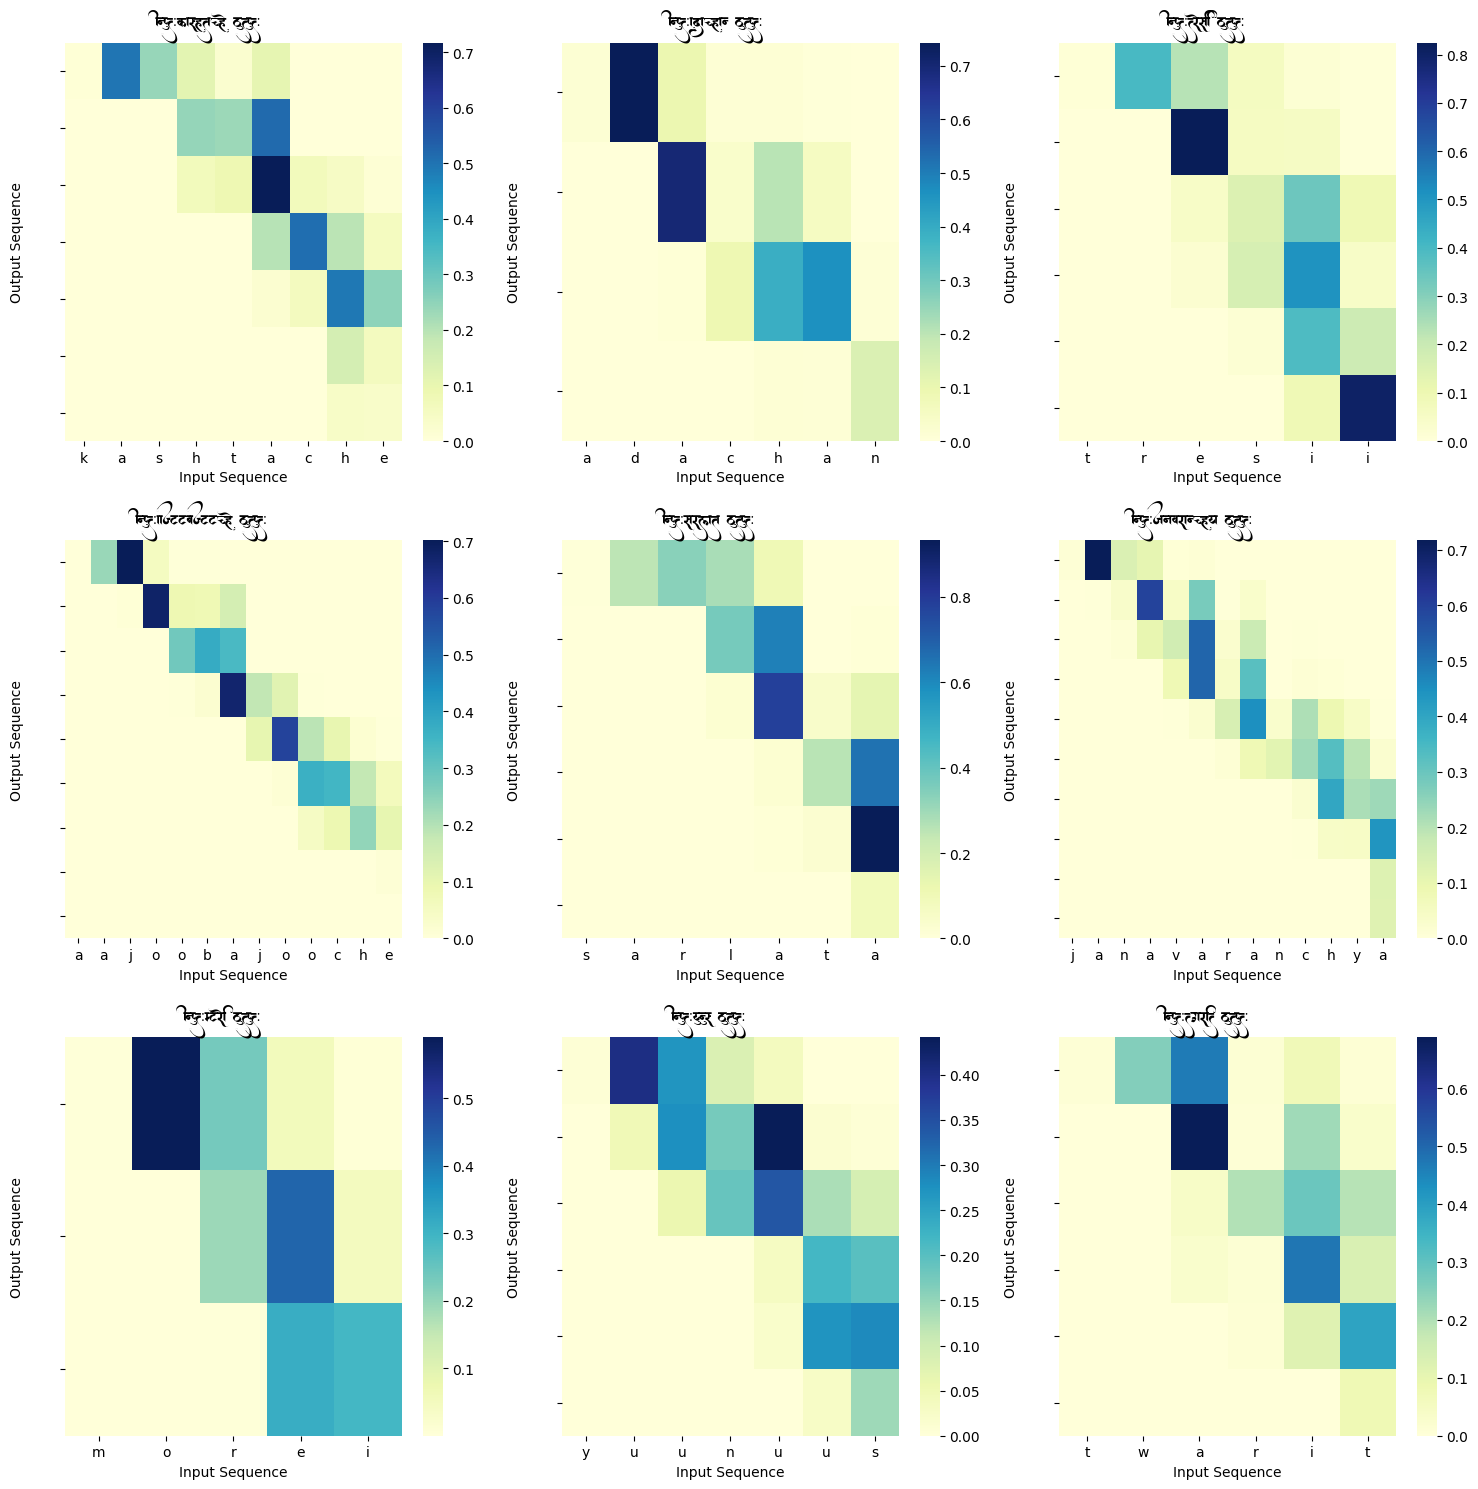

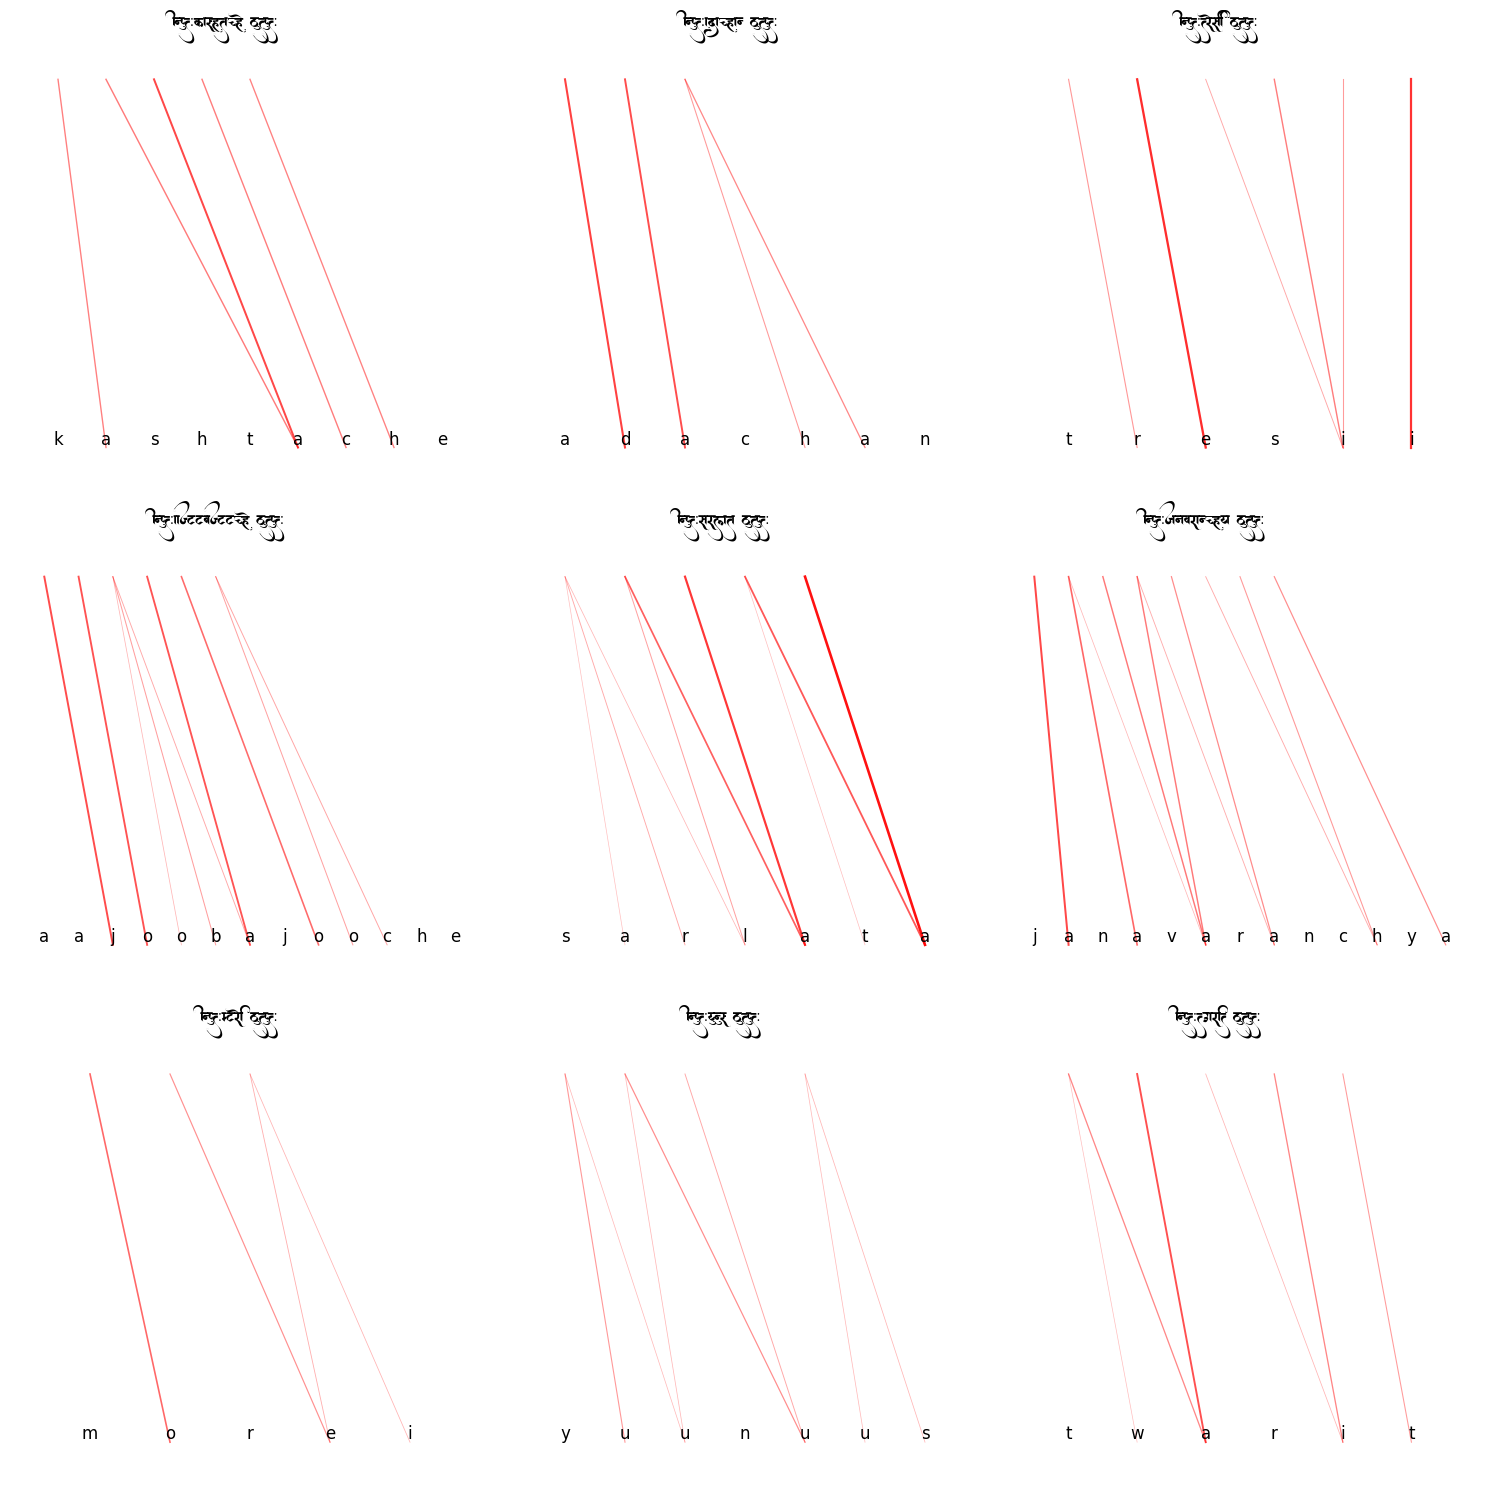

In [152]:
test_seq2seq_model(best_run_config)